# Introduction
 - Sprint: **0**

# Task:
 -  Utworzenie prostego notatnika umożliwiającego: 
  * [wygenerowanie syntetycznego zbioru danych](#1.-Syntetic-data)
  * [uruchomienie procesu uczenia](#2.-Simple-Neural-Network)
  * wizualizację tego procesu

---

# 0. Imports

In [198]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Any, Tuple, Callable

In [199]:
import torch
from torch import nn, Tensor
from torch.utils.tensorboard import SummaryWriter

In [200]:
# Reproducible results
np.random.seed(47)

In [203]:
# Constants
TENSORBOARD_RUNS_DIR = '../runs/'

## 1. Syntetic data

### 1.1 Data generator

In [204]:
class SynteticDataGenerator():

    def __init__(self, gen_function: Callable[[float], float] = None) -> None:
        """ TODO: Doc """
        self.__default_data_gen_function = lambda x: x ** 3 + x ** 2 - 4 * x - 2
        self.data_gen_function = gen_function if gen_function is not None else self.__default_data_gen_function
        
    def get_data_gen_function(self) -> Callable[[float], float]:
        """ Return data generator function """
        return self.data_gen_function
        
    def generate_data(self, num_points: int, r_min: int = -3, r_max: int =  3, noise_multiplier: float = 3) -> Tuple[List[int], List[int]]:
        """ TODO: Doc """
        x = np.random.choice(np.arange(r_min, r_max, 0.01), num_points)
        y = [self.data_gen_function(value) + (np.random.uniform() - 0.5) * noise_multiplier for value in x]
        return (x, y)

### 1.2 Helpers

In [205]:
def compare_outputs(sdg: SynteticDataGenerator, x: List[float], y: List[float]) -> None:
    """ TODO: Doc """

    # Get boundaries
    rx_min, rx_max = min(x), max(x)
    ry_min, ry_max = min(y), max(y)

    # Draw data generation function
    dgx = np.arange(rx_min, rx_max, 0.01)
    dgy = [sdg.get_data_gen_function()(value) for value in dgx]
    plt.plot(dgx, dgy, color='red')

    # Draw points
    plt.scatter(x, y)

    # Show plot
    plt.xlim(rx_min, rx_max)
    plt.ylim(ry_min, ry_max)
    plt.grid(True, linestyle="--")
    plt.show()

### 1.2 Example data

In [231]:
sdg = SynteticDataGenerator()

In [232]:
random_data = sdg.generate_data(100)

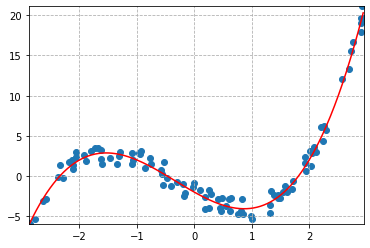

In [233]:
compare_outputs(sdg, *random_data)

---

## 2. Simple Neural Network

### 2.1 Architecture

In [234]:
class NeuralNetwork(nn.Module):
    """ TODO: Doc """
    
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        
        self.fc_network = nn.Sequential(
            nn.Linear(1, 12),
            nn.Sigmoid(),
            nn.Linear(12, 1)
        )
        
    def forward(self, x: Tensor) -> Tensor:
        return self.fc_network(x)
        

### 2.2 Data

In [235]:
original_x, original_y = SynteticDataGenerator().generate_data(120)

In [236]:
x = Tensor([[value] for value in original_x])

In [237]:
y = Tensor([[value] for value in original_y])

### 2.3 Main loop

In [238]:
# Tensorboard writter (writer will output to ./runs/ directory by default)
writer = SummaryWriter(log_dir=TENSORBOARD_RUNS_DIR)

In [239]:
# Hyperparameters
learning_rate = 0.1
num_epochs = 1000

In [240]:
# Define model, Loss and optimizer.
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [241]:
loss_values = []

# Learning
for epoch in range(num_epochs):
    
    # Forward pass
    outputs = model(x)
    
    # Calculate loss
    loss = criterion(outputs, y)
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Save loss
    loss_values.append(loss.item())
    writer.add_scalar('Loss/train', loss.item(), epoch)
       

In [242]:
# Save expermient results
writer.close()

## 3. Results

### 3.1 Loss

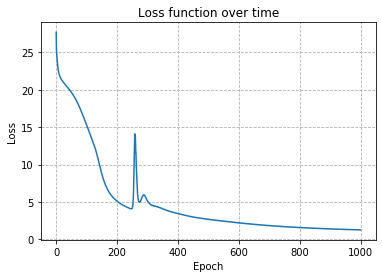

In [243]:
plt.title("Loss function over time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--")
plt.plot(loss_values)

### 3.2 Network output

In [227]:
pred_x, pred_y = [x.flatten().tolist(), [model(value).item() for value in x]]

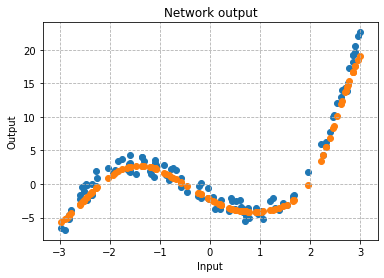

In [228]:
plt.title("Network output")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True, linestyle="--")
plt.scatter(original_x, original_y)
plt.scatter(pred_x, pred_y)

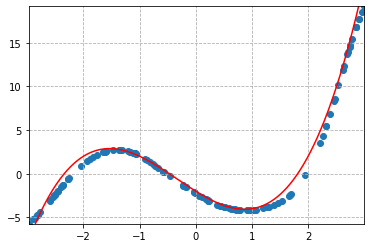

In [230]:
compare_outputs(sdg, pred_x, pred_y)